## 4b) Evaluation of Shap Explainer (Kernel Explainer) - MLPClassifier Model
#### **Note:** Total runtime approx. 8 hours

### This notebook uses two metrics to evalute the effctiveness of SHAP Kernel Explainer 
#### 1. `Robustness to Noise:` 
##### Robustness evaluates how well the explanations handle noisy or perturbed data. Robust explainer-model combinations should exhibit minimal changes in the explanations under such perturbations. 
#### 2. `Stability to Validation: `
##### Stability evalutes how stable the explainer results are for different sets of randomised testing data. A more stable explainer should give similar sets of important features for different testing data.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import hamming_loss, accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np

df = pd.read_csv("../preprocessed/clean_survey.csv", index_col=False)
# split to indenpendent and dependent variables
# drop all variables computing the labels
X = df.drop(['q_031_adjusted', 'invol_score', 'q_031', 'involvement_level'] + [f'q_0{i}' for i in range(45, 55)], axis=1)
y = df["involvement_level"]

# Encode the class labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the dataset into training and test sets
X_train, X_test, y_encoded_train, y_encoded_test = train_test_split(X, y_encoded, stratify=y_encoded, random_state=42)

# Data Preprocessing
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Store in dataframe for plotting
feature_names = X_train.columns.tolist()
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=feature_names)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=feature_names)

label_mapping = {index: label for index, label in enumerate(label_encoder.classes_)}
print(label_mapping)

{0: 'High', 1: 'Low', 2: 'Medium'}


In [2]:
import pickle
# fit the best model
# Load the model from a file
with open('../models/neural_1.pkl', 'rb') as file:
    model1 = pickle.load(file)

In [3]:
import shap
shap.initjs()

# model1 is the trained MLPClassifier model
# Create a SHAP KernelExplainer object
shap_explainer = shap.KernelExplainer(model1.predict_proba, shap.sample(X_train_scaled, 100))

# Compute SHAP values for each sample in the X_test dataset
with open('../shaps/shap_values_kernel.pkl', 'rb') as file:
    shap_values = pickle.load(file)

### 4.1 Robustness to Noise
For the given testing dataset that was used to generate Shapley values, different small noise levels were added to the data to generate perturbed testing samples. Then the explainer was fitted to compute the perturbed Shapley values. To determine robustness, we inspect the correlation between original Shapley values and perturbed Shapley values. The higher the correlations for small noises, the more robust the explainer is to noise.

In [4]:
with open('../shaps/df_feature_contri_kernel.pkl', 'rb') as file:
    df_feature_importances = pickle.load(file)
df_feature_importances
features_to_perturb = df_feature_importances[
    (df_feature_importances['RateOfChange'].isna()) | 
    (df_feature_importances['RateOfChange'] >= 3)
]['Feature'].tolist()
perturb_indices = [X_test.columns.get_loc(col) for col in features_to_perturb]
perturb_indices

[35,
 72,
 21,
 19,
 62,
 59,
 65,
 45,
 53,
 67,
 22,
 18,
 17,
 7,
 25,
 79,
 76,
 4,
 0,
 58,
 80,
 13,
 2]

In [5]:
def add_per_feature_noise(X, noise_level, perturb_indices, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)
    X_noisy = X.copy()
    for i in perturb_indices:
        sigma_j = np.std(X.iloc[:, i])
        feature_noise = np.random.normal(0, noise_level * sigma_j, X.iloc[:, i].shape)
        X_noisy.iloc[:, i] += feature_noise
    return X_noisy

In [6]:
# Set the noise levels to evaluate
noise_levels = [0.005, 0.01, 0.02, 0.05, 0.1, 0.2]
random_seeds = [42, 0, 150, 500, 999] 

# Initialize arrays to store the correlation scores for each class
correlation_scores_kernel = [[] for _ in range(3)]
mae_scores_kernel = [[] for _ in range(3)]
class_index = [1, 2, 0]

# Iterate over the noise levels
for noise_level in noise_levels:
    # Temporary lists to store scores for the current noise level
    temp_corr_scores_kernel = [[] for _ in range(3)]  
    temp_mae_scores_kernel = [[] for _ in range(3) ]
    for seed in random_seeds:
        # Add noise to the test set with different random seeds
        X_test_noisy = add_per_feature_noise(X_test, noise_level, perturb_indices, random_state=seed)
        X_test_noisy = scaler.transform(X_test_noisy)
        # Compute SHAP values for the noisy test set
        shap_values_kernel_noisy = shap_explainer.shap_values(X_test_noisy)
        
        # Compute correlations and MAE for each class
        for class_idx in class_index:
            corr_kernel = np.corrcoef(shap_values[class_idx].flatten(), shap_values_kernel_noisy[class_idx].flatten())[0, 1]
            mae_kernel = np.mean(np.abs(shap_values[class_idx] - shap_values_kernel_noisy[class_idx]))
            temp_corr_scores_kernel[class_idx].append(corr_kernel)
            temp_mae_scores_kernel[class_idx].append(mae_kernel)    
    # Compute the average correlation and MAE for the current noise level
    for class_idx in class_index:
        avg_corr_kernel = np.mean(temp_corr_scores_kernel[class_idx])
        avg_mae_kernel = np.mean(temp_mae_scores_kernel[class_idx])
        correlation_scores_kernel[class_idx].append(avg_corr_kernel)
        mae_scores_kernel[class_idx].append(avg_mae_kernel)



  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

In [7]:
correlation_scores_kernel

[[0.9572141073053217,
  0.95718568120251,
  0.9571009497254135,
  0.9563394101377277,
  0.9535727618919878,
  0.9432786006163338],
 [0.9748288083228598,
  0.9747957299783886,
  0.974681643400095,
  0.9738252113911365,
  0.9707425761977415,
  0.9588315014753789],
 [0.9744020717120836,
  0.9743672413126134,
  0.9742387922693696,
  0.9733862627688236,
  0.9704014593867443,
  0.9588401765703564]]

In [8]:
mae_scores_kernel

[[0.0021864478133757905,
  0.002186995467286591,
  0.002188393900444561,
  0.002202101513324545,
  0.0022502969799189122,
  0.0024024031269630863],
 [0.005657225323362618,
  0.005661129165011343,
  0.00567290339045486,
  0.005757916744912025,
  0.006033284966441401,
  0.006880960129437799],
 [0.005505129553334364,
  0.005508131993811593,
  0.005520759394897533,
  0.005601284319676156,
  0.005857783740808685,
  0.006660698005495345]]

### Whole Feature

In [12]:
def add_per_feature_noise(X, noise_level, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)
    X_noisy = X.copy()
    for i in range(X.shape[1]):
        sigma_j = np.std(X.iloc[:, i])
        feature_noise = np.random.normal(0, noise_level * sigma_j, X.iloc[:, i].shape)
        X_noisy.iloc[:, i] += feature_noise
    return X_noisy

# Set the noise levels to evaluate
noise_levels = [0.005, 0.01, 0.02, 0.05, 0.1, 0.2]
random_seeds = [42, 0, 150, 500, 999] 

# Initialize arrays to store the correlation scores for each class
correlation_scores_kernel = [[] for _ in range(3)]
mae_scores_kernel = [[] for _ in range(3)]
class_index = [1, 2, 0]

# Iterate over the noise levels
for noise_level in noise_levels:
    # Temporary lists to store scores for the current noise level
    temp_corr_scores_kernel = [[] for _ in range(3)]  
    temp_mae_scores_kernel = [[] for _ in range(3) ]
    for seed in random_seeds:
        # Add noise to the test set with different random seeds
        X_test_noisy = add_per_feature_noise(X_test, noise_level, random_state=seed)
        X_test_noisy = scaler.transform(X_test_noisy)
        # Compute SHAP values for the noisy test set
        shap_values_kernel_noisy = shap_explainer.shap_values(X_test_noisy)
        
        # Compute correlations and MAE for each class
        for class_idx in class_index:
            corr_kernel = np.corrcoef(shap_values[class_idx].flatten(), shap_values_kernel_noisy[class_idx].flatten())[0, 1]
            mae_kernel = np.mean(np.abs(shap_values[class_idx] - shap_values_kernel_noisy[class_idx]))
            temp_corr_scores_kernel[class_idx].append(corr_kernel)
            temp_mae_scores_kernel[class_idx].append(mae_kernel)    
    # Compute the average correlation and MAE for the current noise level
    for class_idx in class_index:
        avg_corr_kernel = np.mean(temp_corr_scores_kernel[class_idx])
        avg_mae_kernel = np.mean(temp_mae_scores_kernel[class_idx])
        correlation_scores_kernel[class_idx].append(avg_corr_kernel)
        mae_scores_kernel[class_idx].append(avg_mae_kernel)

  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

In [13]:
correlation_scores_kernel

[[0.9571415392333386,
  0.9570691747958211,
  0.9568691633485145,
  0.9549312773726772,
  0.9474038169547176,
  0.9192219107022466],
 [0.9747044012812086,
  0.9746427416105922,
  0.9743652599796662,
  0.9725735878334693,
  0.9663751818212274,
  0.9432690185944935],
 [0.9744122702650218,
  0.9743344060328981,
  0.9740627809954698,
  0.9722366155648272,
  0.9659217783923125,
  0.942289883618502]]

In [14]:
mae_scores_kernel

[[0.0021931849605311797,
  0.002194629147527977,
  0.002198812765487343,
  0.002237932597859079,
  0.0023693983212240066,
  0.0027839288085538772],
 [0.0056618181769907405,
  0.005669304384701556,
  0.00569959240098813,
  0.00588334451922525,
  0.006443698587832278,
  0.008092214759335161],
 [0.005490527710622468,
  0.00549908061605992,
  0.005526610985682161,
  0.005704863512044461,
  0.006255863879772892,
  0.007898274366448039]]

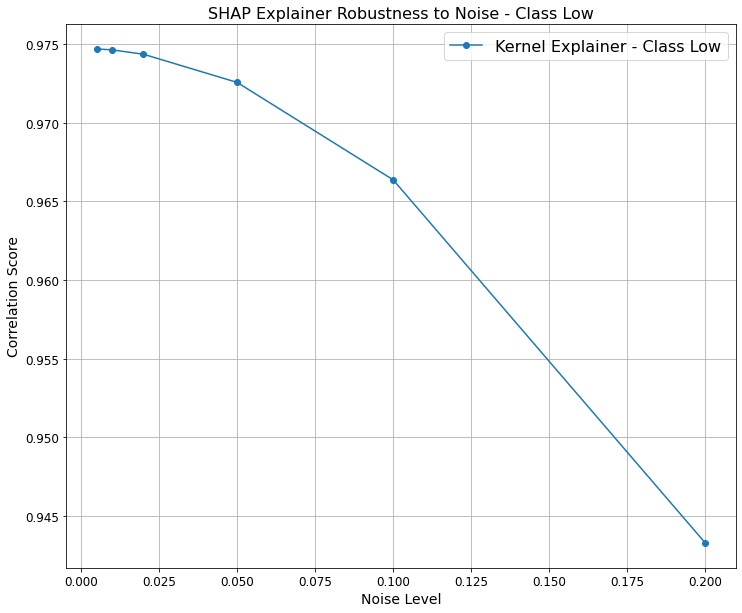

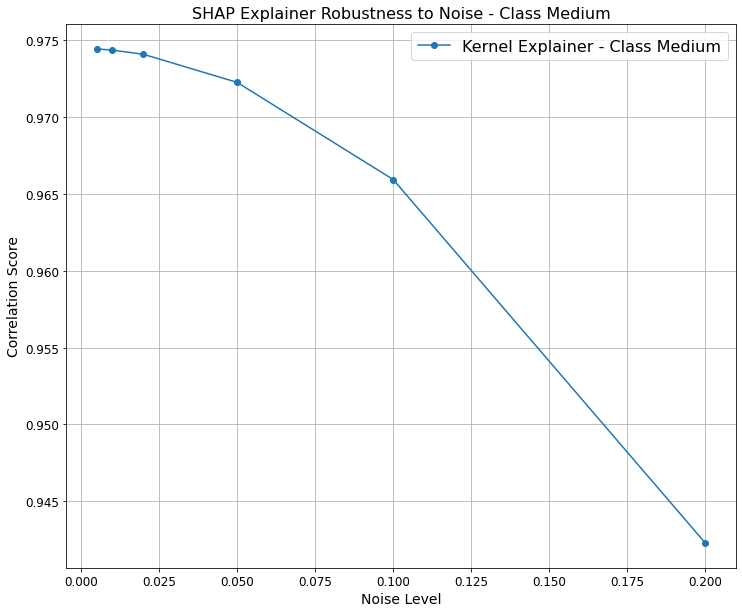

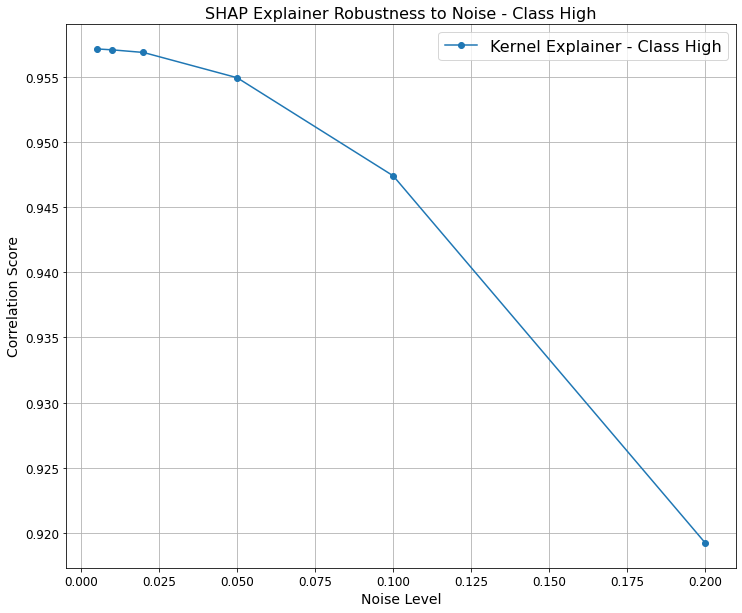

Class Low average rubustness score =  0.9676550318534428
Class Medium average rubustness score =  0.9672096224781718
Class High average rubustness score =  0.9487728137345526


In [7]:
# Plot the correlation scores against noise levels
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

for class_idx in class_index:
    plt.figure(figsize=(12, 10))
    plt.plot(noise_levels, correlation_scores_kernel[class_idx], marker='o', label=f'Kernel Explainer - Class {label_mapping[class_idx]}')
    plt.xlabel('Noise Level', fontsize=14)
    plt.ylabel('Correlation Score', fontsize=14)
    plt.title(f'SHAP Explainer Robustness to Noise - Class {label_mapping[class_idx]}', fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize=16)
    plt.grid(True)
    plt.show()


for class_idx in class_index:
    avg_robustness = np.mean(correlation_scores_kernel[class_idx])
    print(f"Class {label_mapping[class_idx]} average rubustness score = ", avg_robustness)

### 4.2 Stability to Validation
The original testing (validation) set was split with random state 42. Now we use different random states to generate new testing sets for the explainer to compute Shapley values. We then find the list of top 30 influential features for each random state, and compare the similarities between each list. The more similar the lists of influential features, the more stable the explainer.   

In [8]:
def training_generator(X, y_encoded, model, random_states):
    features_list = []
    for random_state in random_states:
        # Split the dataset into training and test sets
        X_train, X_test, y_encoded_train, y_encoded_test = train_test_split(X, y_encoded, stratify=y_encoded, random_state=random_state)

        # Data Preprocessing
        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train_scaled = scaler.transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        #model_weight = evaluation_weighter(model, X_test_scaled, y_encoded_test)
        
        shap_explainer = shap.KernelExplainer(model.predict_proba, X_train_scaled)
        shap_values_scaled = shap_explainer.shap_values(X_test_scaled)
        
        # Retrieve feature names after dropping columns
#        feature_names = X.columns.tolist()
#        expected_value = np.array(shap_explainer.expected_value)
        shap_values_scaled = [np.array(sv) for sv in shap_values_scaled]

        # If shap_values is a multi-output (e.g., for multi-class classification), you need to aggregate across all classes.
        # This code assumes shap_values is structured with one element per class (for multi-class) or just a single array for binary.
        if isinstance(shap_values_scaled, list):  # Multi-class scenario
            # Aggregate SHAP values across all classes, then compute the mean absolute value for each feature
            aggregated_shap = np.sum([np.abs(values) for values in shap_values_scaled], axis=0)
        else:  # Binary classification scenario
            aggregated_shap = np.abs(shap_values_scaled)

        mean_abs_shap_values = np.mean(aggregated_shap, axis=0)

        # Create a DataFrame for easier manipulation and visualization
        df_feature_importances = pd.DataFrame({
            'Feature': X_train.columns,
            'MeanAbsSHAP': mean_abs_shap_values
        }).sort_values(by='MeanAbsSHAP', ascending=False)

        # Step 5: Identify the most important features based on mean absolute SHAP values
        top_features_list = df_feature_importances.head(30)['Feature'].tolist()
        features_list.append(top_features_list)
        
    return features_list


from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, hamming_loss
def evaluation_weighter(model, X_test, y_test):
    # Evaluate the model
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)  # Convert probabilities to class predictions

    # Calculate various metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    # ROC-AUC for multi-class
    roc_auc = roc_auc_score(y_test, y_pred_prob, average='macro', multi_class='ovr')
    weight = (accuracy + f1_weighted + roc_auc) / 3
    return weight

In [9]:
import pickle
# fit the best model
# Load the model from a file
with open('../models/neural_1.pkl', 'rb') as file:
    model1 = pickle.load(file)

In [10]:
random_states = [1, 20, 42, 150, 250, 500, 1000]
importance_feature_lists = training_generator(X, y_encoded, model1, random_states)

Using 656 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/219 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
importance_feature_lists

[['q_025',
  'q_024',
  'q_112',
  'q_109',
  'q_043',
  'q_021',
  'q_119',
  'q_022',
  'q_105',
  'q_008',
  'q_020',
  'q_100',
  'q_005',
  'q_114',
  'q_030',
  'q_000',
  'q_007',
  'q_088',
  'q_003',
  'q_102',
  'q_006',
  'q_106',
  'q_012',
  'q_107',
  'q_120',
  'q_101',
  'q_123_regional',
  'q_009',
  'q_015',
  'q_011'],
 ['q_025',
  'q_109',
  'q_024',
  'q_043',
  'q_119',
  'q_112',
  'q_022',
  'q_021',
  'q_105',
  'q_008',
  'q_020',
  'q_114',
  'q_100',
  'q_030',
  'q_088',
  'q_102',
  'q_007',
  'q_003',
  'q_012',
  'q_120',
  'q_015',
  'q_006',
  'q_000',
  'q_005',
  'q_001',
  'q_107',
  'q_011',
  'q_013',
  'q_009',
  'q_037'],
 ['q_025',
  'q_024',
  'q_109',
  'q_119',
  'q_043',
  'q_112',
  'q_021',
  'q_022',
  'q_105',
  'q_020',
  'q_114',
  'q_088',
  'q_008',
  'q_100',
  'q_030',
  'q_003',
  'q_005',
  'q_000',
  'q_102',
  'q_011',
  'q_006',
  'q_007',
  'q_012',
  'q_107',
  'q_106',
  'q_013',
  'q_120',
  'q_101',
  'q_015',
  'q_009']

In [ ]:
def count_pairwise_common_elements(lists):
    common_counts = {}
    for i in range(len(lists)):
        for j in range(i+1, len(lists)):
            common_elements = set(lists[i]) & set(lists[j])
            common_counts[(i, j)] = len(common_elements)
    return common_counts


pairwise_common_counts = count_pairwise_common_elements(importance_feature_lists)
print("Pairwise common elements counts:")
for pair, count in pairwise_common_counts.items():
    print("Lists {} and {}: {} common elements".format(pair[0]+1, pair[1]+1, count))

Pairwise common elements counts:
Lists 1 and 2: 27 common elements
Lists 1 and 3: 29 common elements
Lists 1 and 4: 28 common elements
Lists 1 and 5: 29 common elements
Lists 1 and 6: 28 common elements
Lists 1 and 7: 28 common elements
Lists 2 and 3: 28 common elements
Lists 2 and 4: 28 common elements
Lists 2 and 5: 27 common elements
Lists 2 and 6: 28 common elements
Lists 2 and 7: 28 common elements
Lists 3 and 4: 29 common elements
Lists 3 and 5: 28 common elements
Lists 3 and 6: 29 common elements
Lists 3 and 7: 29 common elements
Lists 4 and 5: 28 common elements
Lists 4 and 6: 28 common elements
Lists 4 and 7: 29 common elements
Lists 5 and 6: 28 common elements
Lists 5 and 7: 29 common elements
Lists 6 and 7: 29 common elements


In [ ]:
def jaccard_similarity(list1, list2):
    set1 = set(list1)
    set2 = set(list2)
    intersection_size = len(set1.intersection(set2))
    union_size = len(set1.union(set2))
    return intersection_size / union_size

def compute_similarity_scores(lists):
    similarity_scores = []
    for i in range(len(lists)):
        for j in range(i+1, len(lists)):
            similarity_scores.append(jaccard_similarity(lists[i], lists[j]))
    return similarity_scores

pairwise_similarity_scores = compute_similarity_scores(importance_feature_lists)
overall_similarity_score = sum(pairwise_similarity_scores) / len(pairwise_similarity_scores)
print("Overall Jaccard similarity score:", overall_similarity_score)

Overall Jaccard similarity score: 0.8926302192431224
